# data

In [ ]:
DATA_PATH = 'C:\\Users\\stefa\\OneDrive - FHWN\\Privat\\Studium\\MIT_2-Semester\\case_study\\lession1\\datasets\\ukdale2.h5'
from nilmtk import DataSet

ukdale = DataSet(DATA_PATH)
ukdale.set_window(start='2014-04-01', end='2014-07-01')

aggregate = next(ukdale.buildings[1].elec.mains().load(sample_period=10))
aggregate = aggregate['power']['active']
aggregate.head(n=5)

In [ ]:
import nilmtk
import os
import numpy as np

building = 5
appliance = 'microwave'
start_time = '2014-10-01'
end_time = '2014-10-02'
sample_period = 10



ukdale = nilmtk.DataSet(DATA_PATH)
ukdale.set_window(start=start_time, end=end_time)
mains = ukdale.buildings[building].elec.mains().power_series_all_data(sample_period=sample_period, resample_kwargs={'label': 'right'})


c:\Users\stefa\.conda\envs\casestudy2\lib\site-packages\nilmtk\utils.py:499: UserWarning: Not all resample_kwargs were consumed: {'label': 'right'}
  warnings.warn("Not all resample_kwargs were consumed: {}".format(repr(all_resample_kwargs)))


In [ ]:
CSVPATH = 'app\\static\\uploads\\mains.csv'
# mains.to_csv('app\\static\\uploads\\mains.csv')
type(mains)
mains

2014-10-01 00:00:00+01:00    631.391968
2014-10-01 00:00:10+01:00    634.210999
2014-10-01 00:00:20+01:00    631.526978
2014-10-01 00:00:30+01:00    637.171997
2014-10-01 00:00:40+01:00    634.783020
                                ...    
2014-10-01 23:59:10+01:00    308.125000
2014-10-01 23:59:20+01:00    307.385010
2014-10-01 23:59:30+01:00    310.351013
2014-10-01 23:59:40+01:00    308.066010
2014-10-01 23:59:50+01:00    307.515015
Freq: 10S, Name: (power, active), Length: 8640, dtype: float32

In [ ]:
import pandas as pd

mains = pd.read_csv(CSVPATH,header=None).rename(columns={0:'Date',1:'Power'})
mains['Date'] = pd.to_datetime(mains['Date'])
mains = mains.set_index('Date').iloc[:,0]
# type(mains)
mains


Date
2014-10-01 00:00:00+01:00    631.39197
2014-10-01 00:00:10+01:00    634.21100
2014-10-01 00:00:20+01:00    631.52700
2014-10-01 00:00:30+01:00    637.17200
2014-10-01 00:00:40+01:00    634.78300
                               ...    
2014-10-01 23:59:10+01:00    308.12500
2014-10-01 23:59:20+01:00    307.38500
2014-10-01 23:59:30+01:00    310.35100
2014-10-01 23:59:40+01:00    308.06600
2014-10-01 23:59:50+01:00    307.51500
Name: Power, Length: 8640, dtype: float64

-------------------------------------
# Predict

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.dates import DateFormatter
import matplotlib.font_manager
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
DATA_PATH = 'C:\\Users\\stefa\\OneDrive - FHWN\\Privat\\Studium\\MIT_2-Semester\\case_study\\lession1\\datasets\\ukdale2.h5'
WEIGHTS_PATH = 'app\\weights\\seq2seq-temp-weights-microwave-epoch0.h5'
SAMPLE_PERIOD = 30

from nilmtk import DataSet

ukdale = DataSet(DATA_PATH)
ukdale.set_window(start='2014-04-01', end='2014-04-05')

main = next(ukdale.buildings[1].elec.mains().load(sample_period=SAMPLE_PERIOD))
aggregate = main['power']['active']
aggregate.head(n=5)

: 

: 

In [ ]:
microwave = next(ukdale.buildings[1].elec['microwave'].load(sample_period=SAMPLE_PERIOD))
microwave.head(n=5)

physical_quantity,power
type,active
2014-04-01 00:00:00+01:00,1.0
2014-04-01 00:00:30+01:00,1.0
2014-04-01 00:01:00+01:00,1.0
2014-04-01 00:01:30+01:00,1.0
2014-04-01 00:02:00+01:00,1.0


In [ ]:
def normalise(df):
    """
    Normalises the values in df
    """
    mean = df.fillna(method='ffill').values.mean()
    std = df.fillna(method = 'ffill').values.std()
    return mean, std, (df.fillna(method='ffill').values-mean)/std

mean_agg, std_agg, aggregate = normalise(aggregate)
mean_frz, std_frz, fridge = normalise(microwave)

In [ ]:

WINDOW_SIZE =99
aggregate = np.pad(aggregate, (WINDOW_SIZE//2, WINDOW_SIZE//2 +1))
aggregate = np.array([aggregate[i:i+WINDOW_SIZE] for i in range(len(aggregate)-WINDOW_SIZE)])
aggregate = np.expand_dims(aggregate, axis=-1)
aggregate

array([[[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [-0.10708962],
        [-0.11088245],
        [-0.11293422]],

       [[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [-0.11088245],
        [-0.11293422],
        [-0.11329905]],

       [[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [-0.11293422],
        [-0.11329905],
        [-0.11561964]],

       ...,

       [[-0.43604985],
        [-0.44009408],
        [-0.44067422],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[-0.44009408],
        [-0.44067422],
        [-0.43997678],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[-0.44067422],
        [-0.43997678],
        [-0.44010374],
        ...,
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]]], dtype=float32)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense

def return_seq2seq(sequence_length):
    model = Sequential()
    # 1D Conv
    model.add(Conv1D(30,10,activation="relu",input_shape=(sequence_length,1),strides=2))
    model.add(Conv1D(30, 8, activation='relu', strides=2))
    model.add(Conv1D(40, 6, activation='relu', strides=1))
    model.add(Conv1D(50, 5, activation='relu', strides=1))
    model.add(Dropout(.2))
    model.add(Conv1D(50, 5, activation='relu', strides=1))
    model.add(Dropout(.2))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(sequence_length))
    optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='mse', optimizer=optim)
    return model

In [ ]:
microwave_model = return_seq2seq(WINDOW_SIZE)
microwave_model.load_weights(WEIGHTS_PATH)

In [ ]:
y_predict = microwave_model.predict(aggregate)
y_predict

array([[ 3.2770967 ,  4.0781116 ,  5.0574255 , ...,  0.1154248 ,
        -0.00984303,  0.08149867],
       [ 2.9512067 ,  3.7458897 ,  4.7907457 , ...,  0.072578  ,
        -0.03404149,  0.07964575],
       [ 3.0841293 ,  3.9336255 ,  4.989262  , ...,  0.11344908,
         0.01842398,  0.14489016],
       ...,
       [ 0.08764981,  0.17892641,  0.40596932, ...,  0.120195  ,
        -0.08764371, -0.16894937],
       [ 0.15740842,  0.27127418,  0.51491106, ...,  0.08550693,
        -0.15590347, -0.24403149],
       [ 0.16843253,  0.27924985,  0.5500078 , ...,  0.10960822,
        -0.09098554, -0.12312316]], dtype=float32)

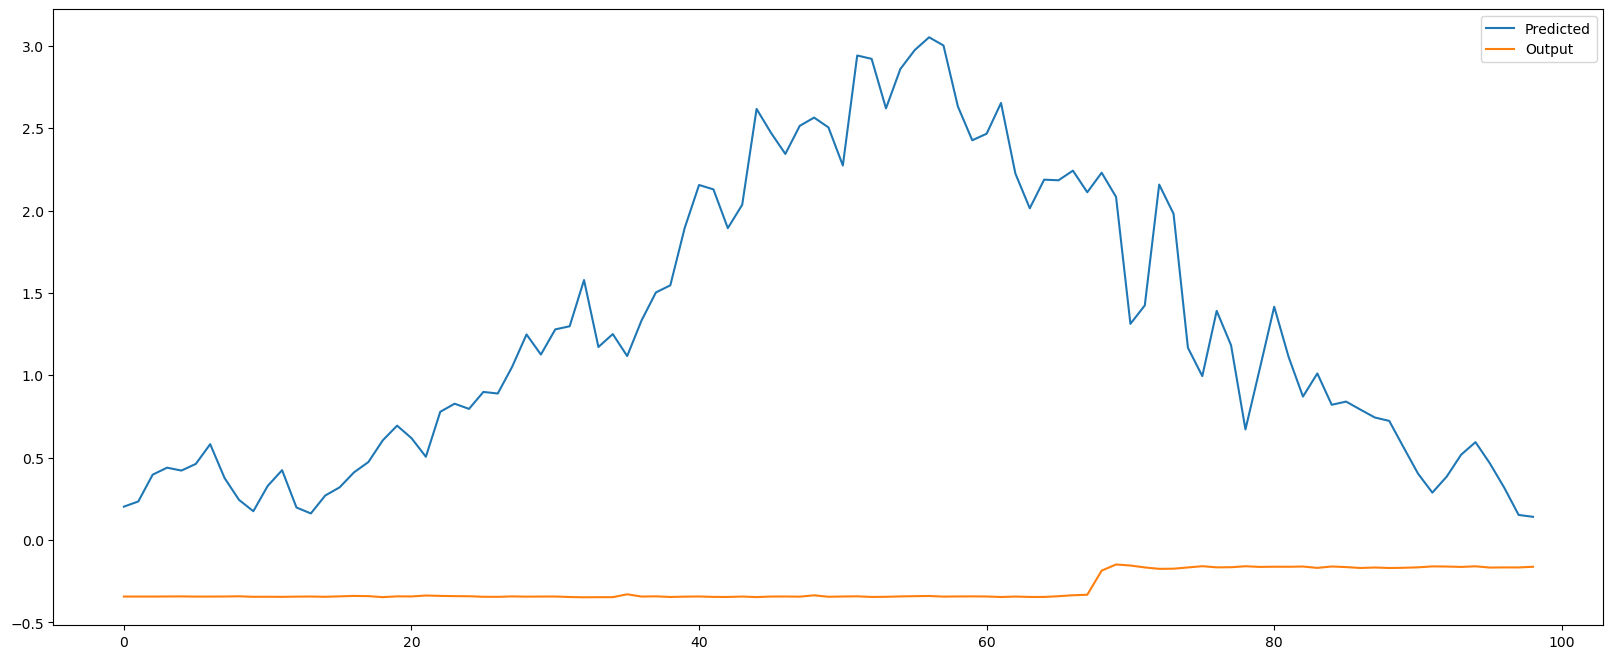

In [ ]:
index = 150
predicted_seq = y_predict[index]
real_seq = aggregate[index]
figure(figsize=(20,8))
plt.plot(predicted_seq, label='Predicted')
plt.plot(real_seq, label='Output')
plt.legend()
plt.show()

In [ ]:
def denormlise(array, mean, std):
    return array*std+mean

def aggregate_sequences(prediction):
    l = WINDOW_SIZE
    n = len(prediction) + l - 1
    sum_arr = np.zeros((n))
    counts_arr = np.zeros((n))
    o = len(sum_arr)
    for i in range(len(prediction)):
        sum_arr[i:i + l] += prediction[i].flatten()
        counts_arr[i:i + l] += 1
    for i in range(len(sum_arr)):
        sum_arr[i] = sum_arr[i] / counts_arr[i]
    return denormlise(sum_arr, mean_frz, std_frz)

y_predict = aggregate_sequences(y_predict)
y_real = aggregate_sequences(aggregate)

In [ ]:
y_predict.shape


(11618,)

In [ ]:
y_real.shape
y_real[0]

7.187527179718018

In [ ]:
aggregate.dropna().shape

(11520,)

[]

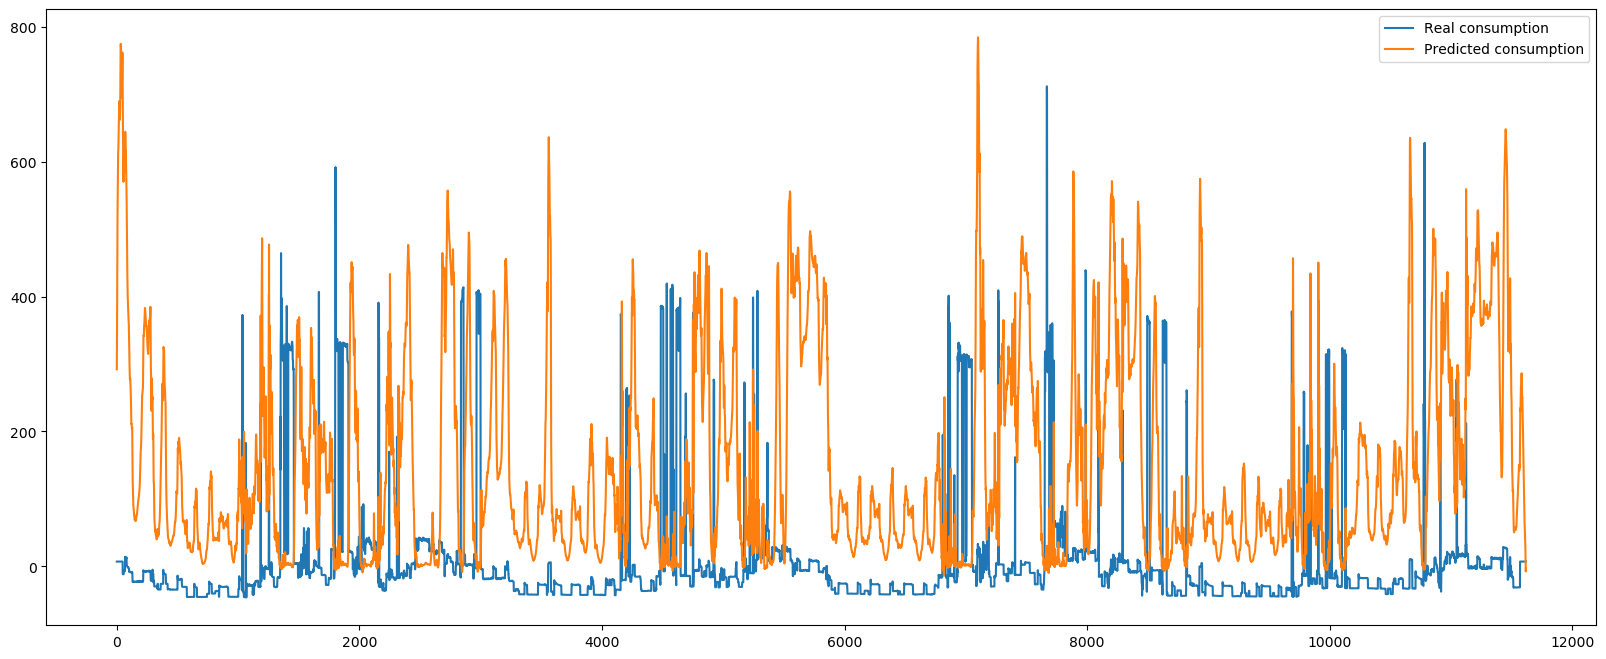

In [ ]:
figure(figsize=(20,8))
plt.plot(y_real, label='Real consumption')
plt.plot(y_predict, label='Predicted consumption')
plt.legend()
plt.plot()

In [ ]:
y_predict

array([292.12315373, 312.7786307 , 351.71569807, ...,   0.94919432,
        -7.37693237,  -3.51773356])

## Prod Test

In [ ]:
SUPPORTED_APPLIANCES = {
    "washingmachine":{
        "name":"Washing Machine",
        "seq2seq_weights":"seq2seq-temp-weights-washing_machine-epoch0.h5"},
    "fridge":{
        "name":"Fridge",
        "seq2seq_weights":"seq2seq-temp-weights-fridge-epoch0.h5"},
    "microwave":{
        "name":"Microwave",
        "seq2seq_weights":"seq2seq-temp-weights-microwave-epoch0.h5"},
    "kettle":{
        "name":"Kettle",
        "seq2seq_weights":"seq2seq-temp-weights-kettle-epoch0.h5"}
        }
SAMPLE_PERIOD = 10
WINDOW_SIZE = 99

WEIGHTS_PATH = os.path.join(BASEDIR,"app","weights",SUPPORTED_APPLIANCES[appliance]['seq2seq_weights'])


data = pd.read_csv(CSVPATH,header=None).rename(columns={0:'Date',1:'Power'})
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
# data
aggregate2 = data['Power']
aggregate2.head(n=5)


Date
2014-10-01 00:00:00+01:00    631.39197
2014-10-01 00:00:10+01:00    634.21100
2014-10-01 00:00:20+01:00    631.52700
2014-10-01 00:00:30+01:00    637.17200
2014-10-01 00:00:40+01:00    634.78300
Name: Power, dtype: float64

In [ ]:
mean_agg, std_agg, aggregate2 = normalise(aggregate2)

aggregate2 = np.pad(aggregate2, (WINDOW_SIZE//2, WINDOW_SIZE//2 ))
aggregate2 = np.array([aggregate2[i:i+WINDOW_SIZE] for i in range(len(aggregate2)-WINDOW_SIZE)])
aggregate2 = np.expand_dims(aggregate2, axis=-1)
aggregate2

AttributeError: 'numpy.ndarray' object has no attribute 'fillna'

In [ ]:
WEIGHTS_PATH
model = return_seq2seq(WINDOW_SIZE)

model.load_weights(WEIGHTS_PATH)
predict = model.predict(aggregate)
predict



array([[ 3.2770967 ,  4.0781116 ,  5.0574255 , ...,  0.1154248 ,
        -0.00984303,  0.08149867],
       [ 2.9512067 ,  3.7458897 ,  4.7907457 , ...,  0.072578  ,
        -0.03404149,  0.07964575],
       [ 3.0841293 ,  3.9336255 ,  4.989262  , ...,  0.11344908,
         0.01842398,  0.14489016],
       ...,
       [ 0.08764981,  0.17892641,  0.40596932, ...,  0.120195  ,
        -0.08764371, -0.16894937],
       [ 0.15740842,  0.27127418,  0.51491106, ...,  0.08550693,
        -0.15590347, -0.24403149],
       [ 0.16843253,  0.27924985,  0.5500078 , ...,  0.10960822,
        -0.09098554, -0.12312316]], dtype=float32)

In [ ]:
data['microwave'] = 

,Power
Date,
2014-10-01 00:00:00+01:00,631.39197
2014-10-01 00:00:10+01:00,634.21100
2014-10-01 00:00:20+01:00,631.52700
2014-10-01 00:00:30+01:00,637.17200
2014-10-01 00:00:40+01:00,634.78300
...,...
2014-10-01 23:59:10+01:00,308.12500
2014-10-01 23:59:20+01:00,307.38500
2014-10-01 23:59:30+01:00,310.35100
